# NumPy, Object-oriented Programming, and Parallel Computing


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import multiprocess

## NumPy

`NumPy` is a library that supplies two major features. 
 - better support for large multi-dimensional arrays. 
 - high-level mathematical functions that operate on them.
 
In summary, `NumPy` (+`Matplotlib`) allows you to use Matlab in Python.

We will illustrate `NumPy` using an example in Stock et al. (2002) that shows how IV estimates might be biased toward the OLS estimates when the instrument is weak. Consider the following data generating process
$$\begin{aligned}
    D_i &= \gamma Z_i + V_i,  \\
    Y_i &= \beta D_i + U_i, \\
    (U_i, V_i) &\sim Normal(0, \Omega), \\
    \Omega &= \begin{pmatrix}
        1 & \rho \\
        \rho & 1
    \end{pmatrix} \\
    Z_i &\sim Normal(0, \sigma^2)
\end{aligned}$$
where $\beta = 0$, $\sigma = 1$, and $\rho = 0.99$.

Note that this is a classical IV regression, where we are interested in estimating $\beta$ and we instrument $D$ with $Z$. The purpose of this simulation is to show how the distribution of $\hat{\beta}$ changes as we alter the magnitude of $\gamma$, (i.e. the strength of the first stage). 

We will draw $N = 1,000$ observations from the data generating process and run simulations.

In [2]:
N = 1000

beta = 0
sigma = 1
rho = 0.99

### Create a NumPy Array

Our first step is to construct all the relevant matrices. This part is very similar to Robin's lecture on Intro to Matlab. There are three common ways to create a numpy array.

1. Create an array from a list: `A = np.array(list)`
2. Create an array of 0s / 1s: `B = np.zeros((nrow, ncol))` or `C = np.ones((nrow, ncol))` 
3. Create a random array: `C = np.random.rand(nrow, ncol)` or other functions from `np.random`

In [3]:
A = np.array([[1,2],[3,4],[5,6]])
print(A)

[[1 2]
 [3 4]
 [5 6]]


In [4]:
B1 = np.zeros((2, 3))
B2 = np.ones((2, 3))
print(B1)
print(B2)

[[0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]]


In [5]:
np.random.seed(42)
C = np.random.rand(4, 1)
C

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       [0.59865848]])

Access element in the array

In [6]:
print(A[0,:]) #i-th row
print(A[:,1]) #j-th column
print(A[0,1]) # (i,j) coordinate

[1 2]
[2 4 6]
2


Get the dimension and number of elements of an array

In [7]:
print(A.shape)
print(A.size)

(3, 2)
6


Now, let's construct the arrays in our example. Recall that 
$$\begin{aligned}
    D_i &= \gamma Z_i + V_i,  \\
    Y_i &= \beta D_i + U_i, \\
    (U_i, V_i) &\sim Normal(0, \Omega), \\
    \Omega &= \begin{pmatrix}
        1 & \rho \\
        \rho & 1
    \end{pmatrix} \\
    Z_i &\sim Normal(0, \sigma^2)
\end{aligned}$$


In [8]:
Sigma = np.array([[1, rho], [rho, 1]])
Sigma

array([[1.  , 0.99],
       [0.99, 1.  ]])

In [9]:
Z = np.random.normal(0, sigma, N)
Z.shape

(1000,)

In [10]:
UV = np.random.multivariate_normal([0, 0], Sigma, N)
print(UV.shape)
U = UV[:,0]
V = UV[:,1]

(1000, 2)


### NumPy Array Operation

Scaler multiplication (`*`) and addition (`+`):

In [11]:
A = np.array([[1,2],[3,4]])
B = np.array([[1,0],[0,1]])
print(2 * A)
print(A + B)

[[2 4]
 [6 8]]
[[2 2]
 [3 5]]


Element-wise multiplication (`*`) and Matrix multiplication `@`

In [12]:
print(A * B)
print(A @ B)

[[1 0]
 [0 4]]
[[1 2]
 [3 4]]


Sum of an array

In [13]:
A.sum()

10

Get the transpose a matrix

In [14]:
A.transpose()

array([[1, 3],
       [2, 4]])

Other useful operation from linear algebra (`np.linalg`): norm, determinant, inverse, and solve linear equations

In [15]:
print(np.linalg.norm(A))
print(np.linalg.det(A))
print(np.linalg.inv(A))
print(np.linalg.solve(A, B))

5.477225575051661
-2.0000000000000004
[[-2.   1. ]
 [ 1.5 -0.5]]
[[-2.   1. ]
 [ 1.5 -0.5]]


Now, we are able to construct the rest of matrices.

In [16]:
gamma = 0.25
D = gamma * Z + V
Y = beta * D + U

Sanity check: compute the mean, variance, and correlation between $U$ and $V$

In [17]:
print(U.sum() / U.size)
print(U.mean())

print(np.sqrt(((U - U.mean())**2).mean()))
print(U.std())

print((U @ V) / (np.linalg.norm(U) * np.linalg.norm(V)))

-0.026050794586944755
-0.026050794586944755
0.9736366557398173
0.9736366557398173
0.9891263962001459


We can also compute the OLS and IV estimates: 
$$\begin{aligned}
    \hat{\beta}_{OLS} = (D'D)^{-1}(D'Y) \\
    \hat{\beta}_{IV} = (Z'D)^{-1}(Z'Y)
\end{aligned}$$

But before doing that, we want to _reshape_ our arrays (from 1d array to 2d arrays).

In [18]:
D.shape

(1000,)

In [19]:
D = D.reshape(N, 1)
print(D.shape)

Y = Y.reshape(N, 1)
Z = Z.reshape(N, 1)

(1000, 1)


Get the OLS and IV estimates

In [20]:
beta_ols = np.linalg.inv(D.transpose() @ D) @ (D.transpose() @ Y)
print(beta_ols)
beta_iv = np.linalg.inv(Z.transpose() @ D) @ (Z.transpose() @ Y)
print(beta_iv)

[[0.93514913]]
[[0.00804841]]


Recall that the the true value is 0. The IV estimate (-0.02) is very close to the true value while OLS is more biased (0.94).

One might argue that the result I showed above is just from one simulation. We should do the same simulation for several times and plot the whole distribution. And that's totally correct. Before doing this, we would like to introduce OOP. 

---

## Object-Oriented Programming (OOP)


### What is OOP?

OOP is a programming paradigm that focuses on the concept of classes and objects. It provides a mechanism to define new data structures with attributes and methods that are allowed only on the data structure you defined.

- a class is the definition of a new data type.
- objects are specific instances of that data type.


### Why you should know about OOP? 

- OOP helps you abstract the problem and leads you to write reusable codes.
- Understanding OOP can help you learn other packages faster (since they are usually designed based on OOP).
    - NumPy: numpy.ndarray()
    - Pandas: pandas.DataFrame()
    - GeoPandas: geopandas.GeoDataFrame() (Thursday)
    - Shapely: shaply.Polygon() (Thursday)
    - BeautifulSoup: bs4.BeautifulSoup() (Friday) 
    - ScikitLearn: sklearn.linear_model.Lasso(), etc. 
- OOP is not a feature of Python. You can apply OOP in other langauges (MATLAB).

### Let's apply OOP in building the simulation

First, consider the simulation process:

```
for each iteration,
    A data generator draws a sample (Y, D, Z)
    An OLS estimator computes the OLS estimate using the sample data
    An IV estimator computes the IV estimate using the sample data
```

The concept of a data generator and an estimator naturally emerge. As a result, we are going to construct this two classes: `DataGenerator` and `Estimator`. 

Let's start from `DataGenerator`. 

1. First, note that the data generating process can be uniquely determined by a few parameters in our model (i.e. $\gamma$, $\beta$, $\sigma$, and $\rho$). If two data generators have the same parameters, then we would not be able to distinguish them. These parameters are what we called **attributes** in OOP.
2. Once we declare all the parameters, we can write a **method** that the object can use to draw a random sample $(Y_i, D_i, Z_i)$ of size $N$ from the data generating process.

In [21]:
class DataGenerator:
    
    def __init__(self, gamma, beta, sigma, rho):
        '''
        Initiate a DataGenerator
        '''
        self.seed = 42
        self.gamma = gamma
        self.beta = beta
        self.sigma = sigma
        self.rho = rho
        np.random.seed(self.seed)
        
    def draw_sample(self, N):
        '''
        Draw a random sample of size N from the data generating process.
        '''
        Z = np.random.normal(0, self.sigma, N)
        Sigma = np.array([[1, self.rho], [self.rho, 1]])
        UV = np.random.multivariate_normal([0, 0], Sigma, N)
        U = UV[:,0]
        V = UV[:,1]
        D = self.gamma * Z + V
        Y = self.beta * D + U

        Y = Y.reshape(N, 1)
        D = D.reshape(N, 1)
        Z = Z.reshape(N, 1)
        
        return (Y, D, Z)

That's it! Now, let's construct an `DataGenerator` object and draw a sample.

In [22]:
data_generator = DataGenerator(gamma=0.25, beta=0, sigma=1, rho=0.99)
Y, D, Z = data_generator.draw_sample(N=1000)

Recall that the syntax of using a function was `f(a, b, c)`, which means that _we_ apply the function $f$ on $(a,b,c)$.

Note that `DataGenerator.draw_sample` is called a **method** instead of a **function**. The syntax of using an object's method is `object.f(a, b)`, which means that the _object_ uses the method with $(a,b)$. In our setting, the data generator _draw_ a sample based on the input sample size $N$. We are really writing codes in human language with **subjects** and **verbs**!

Now, let's construct the estimator object. Similarly we need to think about how we can describe the estimator. In this case, the most intuitive way is to specify whether we want to run use IV or not.

In [23]:
class Estimator:
    
    def __init__(self, spec):
        '''
        Initiate an Estimator
        '''
        self.spec = spec
            
    def fit(self, Y, D, Z):
        '''
        Estimate the OLS or IV estimate
        '''
        assert Y.shape[0] == D.shape[0]
        assert D.shape[0] == Z.shape[0]
        
        N = Y.shape[0] 

        if self.spec == "OLS":
            beta = np.linalg.inv(D.transpose() @ D) @ (D.transpose() @ Y)
            beta = beta[0,0]
        elif self.spec == "IV":
            beta = np.linalg.inv(Z.transpose() @ D) @ (Z.transpose() @ Y)
            beta = beta[0,0]
        else:
            beta = None
            
        return beta

Let's create an OLS estimator and an IV estimator:

In [24]:
ols_estimator = Estimator("OLS")
iv_estimator = Estimator("IV")
beta_ols = ols_estimator.fit(Y, D, Z)
beta_iv = iv_estimator.fit(Y, D, Z)
print(beta_ols, beta_iv)

0.9362273784887223 -0.06016958682084626


Now, we are ready to convert the pseudo-code to real code and run some simulations. Recall that the pseudo-code was

```
for each iteration,
    A data generator draws a sample (Y, D, Z)
    An OLS estimator computes the OLS estimate using the sample data
    An IV estimator computes the IV estimate using the sample data
```

In [25]:
def simulation(data_generator, ols_estimator, iv_estimator):
    '''
    Generate data using data_generator and output beta_ols and beta_iv
    '''
    Y, D, Z = data_generator.draw_sample(N=1000)
    beta_ols = ols_estimator.fit(Y, D, Z)
    beta_iv = iv_estimator.fit(Y, D, Z)
    return (beta_ols, beta_iv)


data_generator = DataGenerator(gamma=0.25, beta=0, sigma=1, rho=0.99)
ols_estimator = Estimator("OLS")
iv_estimator = Estimator("IV")

M = 10000
result_dict = {"OLS":[], "IV":[]}
for _ in range(M):
    beta_ols, beta_iv = simulation(data_generator, ols_estimator, iv_estimator)
    result_dict["OLS"].append(beta_ols)
    result_dict["IV"].append(beta_iv)

Let's plot the density of OLS and IV estimates

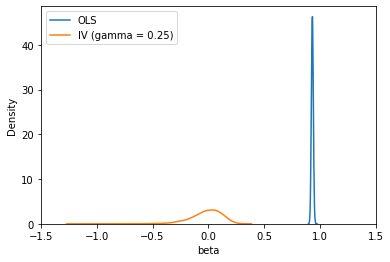

In [26]:
seaborn.kdeplot(result_dict["OLS"], label="OLS")
seaborn.kdeplot(result_dict["IV"], label=f"IV (gamma = {data_generator.gamma})")
plt.xlabel("beta")
plt.xlim([-1.5, 1.5]);
plt.legend(loc='upper left')
plt.show()

In practice, you probably do not need to build classes for running such a simple model; I picked a simple model just for illustrating the general idea of OOP. Just as a recap, we usually do the following:

1. Build a **Dataset** object that collects all the relevant data required for estimation.
2. Build an **Estimator** object that takes in the Dataset object and output the estimates.

In fact, this workflow is very commonly used in our projects that involve estimating complex structural models using customized estimation strategies, (although we mainly use Matlab for this kind of projects.) 

Also in Python, usually you do not need to build your own dataset and estimator object. For instance:

- `pandas.DataFrame` is the most commonly used dataset object
- `scikit-learn` provides a lot of estimation objects such as `LASSO`.

---

## Parallel Computing

Recall that our goal is to see how the distribution of $\hat\beta$ changes as $\gamma$ changes. Currently, we only estimate the $\hat\beta$ for one single $\gamma$. Let's implement this new simulation to compare IV estimates from different data generating process.

In [27]:
gammas = [0.25, 0.20, 0.15, 0.10, 0.05, 0.025, 0]
generators = [DataGenerator(gamma=g, beta=0, sigma=1, rho=0.99) for g in gammas]

def simulation(generator):
    
    M = 10000
    gamma = generator.gamma
    estimates = []
    
    for _ in range(M):
        Y, D, Z = generator.draw_sample(N=1000)
        beta_iv = iv_estimator.fit(Y, D, Z)
        estimates.append(beta_iv)
        
    estimates = np.array(estimates)
    return {"gamma": gamma, "estimates": estimates}

In [28]:
%%time

results = []
for generator in generators:
    results.append(simulation(generator))

CPU times: user 11.8 s, sys: 81.6 ms, total: 11.9 s
Wall time: 11.7 s


It took 11s to complete the simulation procedure. This is super slow. Can we do it faster?


A key insight is that the whole simulation process for one $\gamma$ value is completely independent of the simulation for another $\gamma$. In scenarios like this, we should always consider _parallel computing_. The general idea is that, if the computation processes are independent, instead of running the computation on one computer, we should use several computers to compute them simultaneously.

Parallel Computing is a facinating subject itself, but because of the time constraint, I will focus on the `multiprocess` package. Specifically, I'll show how we can use this package to assign the simulation tasks for different gamma to different cores of the CPU and run simulations simultaneously.

First, let's get the number of CPU cores we have:

In [29]:
n_cpu = multiprocess.cpu_count()
n_cpu

8

In [30]:
num_process = min(len(gammas), n_cpu-1)
num_process

7

We use the `multiprocess.Pool` class, which represents a pool of worker processes. We can use its `Pool.map(f, list)` method to evaluate `f` for all elements in `list`.

In [31]:
%%time

with multiprocess.Pool(processes=num_process) as pool:
    results = pool.map(simulation, generators)

CPU times: user 14.4 ms, sys: 51.6 ms, total: 66 ms
Wall time: 2.84 s


It now takes less than 3 seconds to complete the simulation. You should always think about how to introduce multiprocessing whenever you are running a for-loop where the result of one iteration is independent of another one. This is especially important when you are planning to run the script on the server, since servers usually have much more cores than your laptop. For example, you may use 28 cores in one node on Acropolis.

Finally, we are able to answer our question: how the distribution of $\hat{\beta}$ changes as we alter the magnitude of $\gamma$?

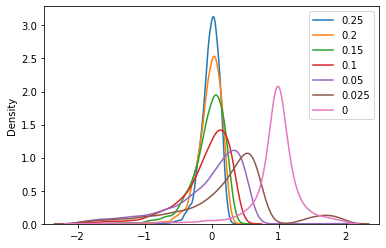

In [32]:
for result in results:
    gamma = result["gamma"]
    estimates = result["estimates"]
    estimates = estimates[(estimates >= -2) & (estimates <= 2)]
    seaborn.kdeplot(estimates, label=f"{gamma}")
plt.xlim([-2.5, 2.5]);
plt.legend();

From the plot above, we can observe that as the strength of the first stage gets weaker, 
- the IV estimate becomes biased toward the OLS estimate;
- the empirical distribution of the IV estimate is no longer bell-shaped.

## Reference

- CMSC 12100 by Borja Sotomayor
- ECON 31720 by Alexander Torgovitsky